# Data cleaning cont. and machine learning

This notebook is created to faciliate the coding tutorial sessions of the Jumpstart Summer Program 2023 @ Data Sciences and Operations Department, USC Marshall. 
If you have any questions, please contact yanfeizh@marshall.usc.edu.

* [Section 1: Data pre-processing cont.](#section1)
    * [Handling missing data/corrupted data cont.](#section1_1)
    * [Scaling numeric variables](#section1_2)
    * [Encoding categorical variables](#section1_3)
    * [Dealing with imbalanced data](#section1_4)
* [Section 2: Introduction to machine learning](#section2)
    * [Supervised and unsupervised learning](#section2_1)
    * [Linear regression and logistic regression](#section2_2)
* [Exercise](#exercise)
* [Future reading (optional)](#reading)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image 

sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

# Section 1: Data pre-processing cont. <a class="anchor" id="section1"></a>

### Missing data/inconsistent data (quick recap and more) <a class="anchor" id="section1_1"></a>

Missing values refer to situations when no record is available for a particular data point. In practice, missing values can occur due to various reasons, such as incomplete data entry, non-response surveys, partial data loss, and other factors. 

Inconsistent data refers to cases where some data values are entered in a contradictory manner, leading to inconsistencies within the dataset or with real-world facts. Such inconsistencies can arise due to manual input errors, variations in data entry conventions or standards, a lack of validation checks, and other factors. 

When conducting data analysis, missing data and inconsistent data can reduce the usability of your statistical models (the power, how much one can learn from the data), potentially causing biased and incorrect parameter estimations or prediction results, and may not accurately represent the population under study


How to handle missing data and inconsistent data depends on the specific problem of study and the requirements of the context. However, there are some general rules that can be followed:

- __Handling missing values__: (covered in tutorial 2)
    - Discard the rows with missing entries (probably the best strategy when the missing proportion is small).
    - Impute by the best guess (e.g., impute by mean/median for numeric features, impute by mode for categorical features, or impute by modeling the missing entries using other features).
    - Encode as a separate group (if there are reasons to believe that rows with missing values should behave in a way that is different from others).
    

- __Inconsistent data__: (our focus today)
    - Detecting inconsistent data
        - Visualize
        - Use interquartile range (IQR)
        - Compute Z-score
        - Conduct hypothesis testing
    - Handling inconsistent data
        - Keep it if it is reasonable
        - Discard the rows with inconsistent values
        - Replace the inconsistent value (by capping/flooring, or replacing with mean/mode)


Let's begin by detecting the inconsistent entries. We will use the Titanic dataset again.

In [2]:
data = pd.read_csv('data/titanic.csv')

Firstly, we attempt the most intuitive way to detect inconsistent data - by plotting the distribution of a variable. For example, we can create a histogram for the variable 'Fare' and observe that the data is highly skewed. Most samples have a value less than 300, but there are indeed a few samples with fares greater than 500, which could be potential outliers.

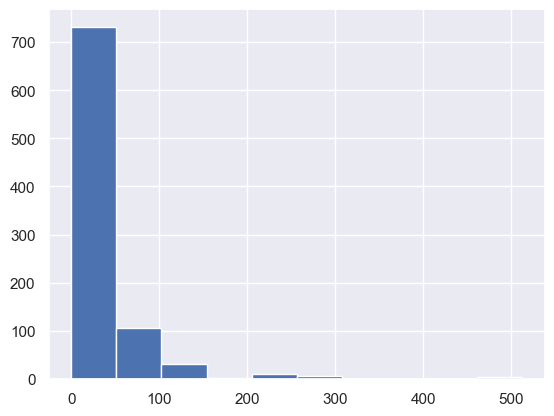

In [3]:
plt.hist(data['Fare'])
plt.show()

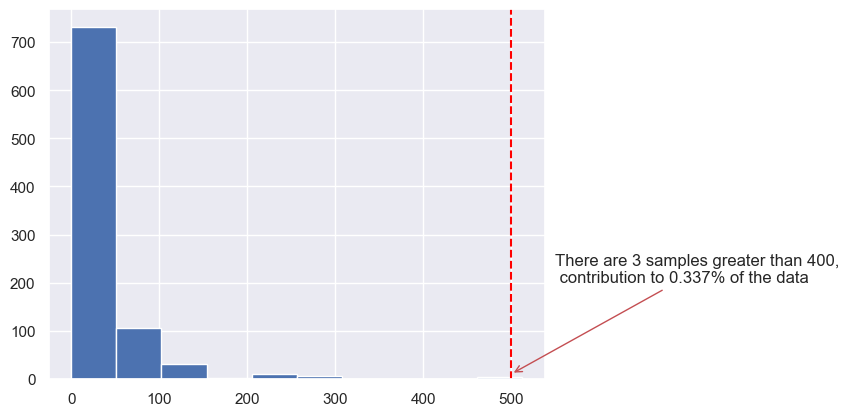

In [4]:
plt.hist(data['Fare'])

# Add a dashed line to indicate 500 threshold
plt.axvline(x=500, color='red', linestyle='--')
arrow_start = (550, 200)   # Starting point of the arrow
arrow_end = (500, 10)     # Endpoint of the arrow
plt.annotate(
    'There are {} samples greater than 400, \n contribution to {:.3f}% of the data'\
         .format(data[data['Fare']>500].shape[0], (data[data['Fare']>500].shape[0]/data.shape[0])*100), 
    xy=arrow_end, 
    xytext=arrow_start, 
    arrowprops=dict(color='r', arrowstyle='->')
)
plt.show()

The second way to detect inconsistent data is by using the interquartile range (IQR), a statistical measure that represents the range between the first quartile (25th percentile, the value below which 25% of the data falls) and the third quartile (75th percentile) of a dataset. It provides a measure of the spread or dispersion of the data.

Let's denote the first quartile as $Q_1$ and the third quartile as $Q_3$:

$$
\text{IQR} = Q_3 - Q_1
$$

Data points with values below $Q_1 - 1.5 \times \text{IQR}$ or above $Q_3 + 1.5 \times \text{IQR}$ can be considered as potential outliers, although different thresholds can be used depending on the specific application or context."

In [5]:
Q1 = data['Fare'].quantile(0.25)
Q3 = data['Fare'].quantile(0.75)
IQR = Q3 - Q1
potential_outliers = data[(data['Fare'] < Q1 - 1.5*IQR) | (data['Fare'] > Q3 + 1.5*IQR)]
potential_outliers

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.000,3,2,19950,263.000,C23 C25 C27,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.521,B78,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.000,1,0,PC 17604,82.171,NaN,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.000,1,0,PC 17572,76.729,D33,C
...,...,...,...,...,...,...,...,...,...,...,...,...
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.550,NaN,S
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1,0,17453,89.104,C92,C
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.000,1,1,36928,164.867,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.550,NaN,S


A box plot can also help visualize the IQR and identify potential outliers.

In [6]:
# Source: https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51
Image(url = 'https://www.simplypsychology.org/wp-content/uploads/boxplot-outliers.png')

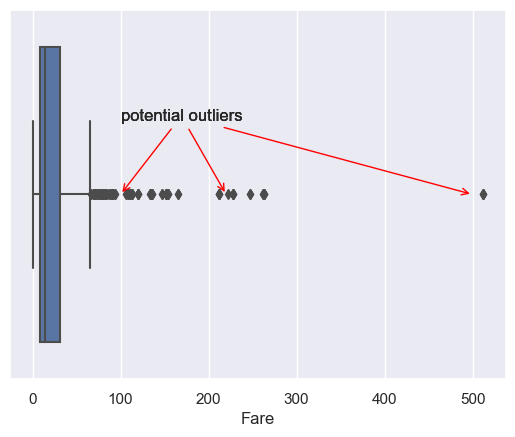

In [7]:
sns.boxplot(x='Fare', data=data)
# Add an arrow to the box plot
plt.annotate('potential outliers', xy=(100, 0), xytext=(100, -0.2),
             arrowprops=dict(color='red', arrowstyle='->'))
plt.annotate('potential outliers', xy=(220, 0), xytext=(100, -0.2),
             arrowprops=dict(color='red', arrowstyle='->'))
plt.annotate('potential outliers', xy=(500, 0), xytext=(100, -0.2),
             arrowprops=dict(color='red', arrowstyle='->'))
    
plt.show()

When the feature follows a normal distribution or when the sample size is large, another method to detect potential outliers is by calculating the z-score. The z-score is defined as:
$$
z = \frac{x - \mu(x)}{\sigma(x)}
$$

Here, $\mu(x) = \frac{1}{N}\sum_{i=1}^N x_i$ represents the mean of the feature $x$, and $\sigma(x) = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \mu(x))^2}$ represents its standard deviation. A z-score of 2 indicates that the data point is 2 standard deviations away from the mean. Typically, any data point with a z-score greater than $+3$ or smaller than $-3$ can be considered a potential outlier.

In [8]:
mu_fare = data['Fare'].mean()
std_fare = data['Fare'].std()
potential_outliers = data[(data['Fare'] < mu_fare - 3*std_fare) | (data['Fare'] > mu_fare+3*std_fare)]
potential_outliers.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.000,3,2,19950,263.000,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.000,3,2,19950,263.000,C23 C25 C27,S
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.000,0,1,PC 17558,247.521,B58 B60,C
258,259,1,1,"Ward, Miss. Anna",female,35.000,0,0,PC 17755,512.329,NaN,C
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.000,0,1,PC 17558,247.521,B58 B60,C


Lastly, we can identify outliers by conducting hypothesis testing, which assumes the following:

- Null hypothesis: all values in the sample were drawn from the same distribution.
- Alternative hypothesis: one value in the sample was not drawn from the same distribution as the other values.

If the p-value for this test is less than a pre-defined significance level (e.g., 0.1), you can reject the null and conclude that one of the values is an outlier. 

### Scaling numeric variables <a class="anchor" id="section1_2"></a>

In statistical modeling and machine learning, standardizing numeric variables ensures that variables with different scales and units can be compared meaningfully, and each variable contributes equally to the analysis. Without standardization, variables with larger ranges or higher variances may unwanted dominate the analysis, leading to biased results. 

There are two commonly used feature scaling methods: 
1. Standardization (or Z-score normalization): prefered when the data is normally distributed. It is a process to rescale the feature so that the feature will have a standard normal distribution (with mean 0 and standard deviation 1)

$$
x_{\text{scaled}} = \frac{x - \mu(x)}{\sigma(x)}
$$

with mean $\mu(x) = \frac{1}{N}\sum_{i=1}^N x_i$, and standard deviation $\sigma(x) = \sqrt{\frac{1}{N}\sum_{i=1}^N (x_i- \mu(x))^2}$



Example: the original scale of the variable 'Fare' in the titanic example is:

In [9]:
num_vars = ['Fare']

rescaled_vars = list(map(lambda x: 'scaled_'+str(x), num_vars))

data[num_vars].describe()

,Fare
count,891.000
mean,32.204
std,49.693
min,0.000
25%,7.910
50%,14.454
75%,31.000
max,512.329


We normalize it with the StandardScalar method from the sklearn package. 

In [10]:
from sklearn.preprocessing import StandardScaler

# define the scaler object (model)
scaler = StandardScaler()

# fit and transform the data
data[rescaled_vars] = scaler.fit_transform(data[num_vars]) 

In [11]:
data[rescaled_vars].describe()

,scaled_Fare
count,891.000
mean,0.000
std,1.001
min,-0.648
25%,-0.489
50%,-0.357
75%,-0.024
max,9.667



2. Normalization (or Min-Max normalization): prefered when data distribution is not normal or the standard deviation is very small. It shrinks the range of the data such that the range is fixed between 0 and 1 (or -1 to 1 if negative values appear).

$$
x_{\text{scaled}} = \frac{x - x_{\text{min}}}{x_{\text{max} - x_{\text{min}}}}
$$



In [60]:
from sklearn.preprocessing import MinMaxScaler

# define the scaler object (model)
scaler = MinMaxScaler()

# fit and transform the data
data[rescaled_vars] = scaler.fit_transform(data[num_vars]) 

In [61]:
data[rescaled_vars].describe()

,scaled_Fare
count,891.000
mean,0.063
std,0.097
min,0.000
25%,0.015
50%,0.028
75%,0.061
max,1.000


*Remark: rescaling numeric variables is not always necessary. For example, if the purpose of the analysis is to present descriptive statistics or summaritive visualizations for the variables, using the original means or medians may be more meaningful. Moreover, some domains or research questions may prioritize the original scale and units of the variables for interpretation.*

### Encoding categorical variables <a class="anchor" id="section1_3"></a>

Categorical variables contain qualitative information representing different categories or groups. In data analysis and machine learning, it is often necessary to encode categorical variables into a numerical format to enable machine learning models to process the data effectively and to facilitate the interpretation of model outputs.

We will introduce two encoding methods for a categorical variable: 
1. One-hot encoding: encode the original categorical variable with a set of binary variables (also called the dummy variables). Each dummy variable represents a category, taking value 1 if the observation matches that category, and 0 otherwise.

For example, let's consider the variable "Embarked" (implies where the traveler mounted from. There are three possible values for Embark — Southampton, Cherbourg, and Queenstown.) with categories "S," "C," and "Q." One-hot encoding transforms this variable into three binary variables: "Embarked_S," "Embarked_C," and "Embarked_Q." For an observation with the category "C," the values would be 0 for "Embarked_Q" and "Embarked_S", and 1 for "Embarked_C".

In [12]:
cat_vars = ['Embarked']

data[cat_vars].head()

,Embarked
0,S
1,C
2,S
3,S
4,S


In [13]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(data[cat_vars])

encoded_vars = encoder.get_feature_names_out(cat_vars)

data[encoded_vars] = encoder.transform(data[cat_vars]).toarray().astype('int')

In [14]:
data[cat_vars+list(encoded_vars)]

,Embarked,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,S,0,0,1,0
1,C,1,0,0,0
2,S,0,0,1,0
3,S,0,0,1,0
4,S,0,0,1,0
...,...,...,...,...,...
886,S,0,0,1,0
887,S,0,0,1,0
888,S,0,0,1,0
889,C,1,0,0,0


2. Label encoding: converts the categorical variable into numerical format by assigning a unique numerical label to each category. Unlike one-hot encoding, label encoding creates a single numerical column instead of multiple binary columns.

In [15]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encoded_vars = list(map(lambda x: 'encoded_'+str(x), cat_vars))

data[encoded_vars] = data[cat_vars].apply(encoder.fit_transform)

In [16]:
data[cat_vars+list(encoded_vars)]

,Embarked,encoded_Embarked
0,S,2
1,C,0
2,S,2
3,S,2
4,S,2
...,...,...
886,S,2
887,S,2
888,S,2
889,C,0


<font color='red'>*Think: what are the potential drawbacks of using one-hot encoding and label encoding? When should each technique be used?* </font>

### Dealing with imbalanced data <a class="anchor" id="section1_4"></a>

Imbalanced data refers to a situation where the distribution of classess is heavily skewed, with one or few classes having significantly fewer samples compared to other classes. This can lead to biased model performance and misleading evaluation result, because the model was fitted favorably to the majority classes. Think about using a traditional evaluation metrics like the predictive accuracy, if a dataset has 95 samples from the class 0 and only 5 samples from the class 1. Then a model that simply predicts class 0 for all instances will achieve an accuracy as high as 95%, even though it fails to detect the minority class, which is actually the class of interest. 

There are many ways to deal with imbalanced data, here we only discuss a few: 
1. Resampling: 
* Oversampling the minority class: Increase the number of instances in the minority class by randomly picking exisiting samples to replicate, or by generating synthetic samples from the minority class using some statistical techniques.
* Undersampling the majority class: Decrease the number of instances in the majority class by randomly removing samples.

2. Reweighting during training: Assign higher weights to the minority class during the training process to emphasize its importance and penalize misclassifications.

3. Picking more appropritate evaluation metrics.

In [17]:
data.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

The Titanic dataset does not appear to have a significant problem of imbalanced data, but here I really want to make the distribution even. :)

In [19]:
majority_class = data[data['Survived']==0]
minority_class = data[data['Survived']==1]

We downsample the majority class by randomly drawing 342 samples from the original majoirty data.

In [20]:
from sklearn.utils import resample

undersampler = resample(majority_class, replace=False, n_samples=342)

In [21]:
undersampler.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,scaled_Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,encoded_Embarked
212,213,0,3,"Perkin, Mr. John Henry",male,22.000,0,0,A/5 21174,7.250,NaN,S,-0.502,0,0,1,0,2
671,672,0,1,"Davidson, Mr. Thornton",male,31.000,1,0,F.C. 12750,52.000,B71,S,0.399,0,0,1,0,2
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.000,NaN,S,-0.648,0,0,1,0,2
16,17,0,3,"Rice, Master. Eugene",male,2.000,4,1,382652,29.125,NaN,Q,-0.062,0,1,0,0,1
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.000,4,2,347082,31.275,NaN,S,-0.019,0,0,1,0,2


# Introduction to machine learning <a class="anchor" id="section2"></a>

### Supervised and unsupervised learning <a class="anchor" id="section2_1"></a>

__Supervised learning__ and __unsupervised learning__ are two machine learning paradigms. 

__Supervised learning__ uses labelled datasets (Each observation are in the form of feature-outcome pair) to train algorithms, aiming to learn the patterns between the features and outcome and predict the outcome for future feature samples. Supervised learning algorithms can be further divided into regression and classification tasks, regression refers to the cases when the outcome is continuous (e.g., household income, insurance quote), and classification refers to the tasks of assigning labels to the categorical (discretized) outcome (e.g., titanic survival outcome, fraudulent detection).

Popular supervised learning algorithms include: 
1. Classical linear models (for regression and classification): linear regression, logistic regression, softmax regression, other generalized linear models.
2. Decision trees (for regression and classification): random forest, xgboost, lightGBM. 
3. Support Vector Machines (SVM) (for regression and classification)
4. K-Nearest Neighbors (KNN)(for regression and classification)
5. Neural Networks (NN): deep neural networks, convolutional neural nets, recurrent neural nets. 
...

__Unsupervised learning__ uses unlabelled datasets (Each observation only contains the feauture) to train algorithms, aiming to learn the patterns within the features 

Popular unsupervised learning algorithms include: 
1. Clustering: K-means clusterings, hierarchical clusterings, guassian mixture model
2. Dimension reduction: Principal component analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE) 


These are many more supervised and unsupervised learning algorithms. In practice, the choice of the algorithm depends on the specific problem, the data characteristics, the sample size, and so on. 

### Linear regression and logistic regression <a class="anchor" id="section2_2"></a>

Linear regression is a simple and fundamental method in statistical/machine learning. It is used for supervised learning tasks to predict an output variable (response, dependent variable, target) based on one or more input features (covariates, explanatory variables, independent variables). It assumes a linear relationship between the output variable and the model parameters.

If there is a single input variable, such linear regression is called simple linear regression. For example, let $Y \in \mathbb{R}$ represent the price of a house (target), and $X \in \mathbb{R}$ record the size of the house measured in square feet (explanatory variable). The goal is to predict the target using the house size. Linear regression is represented by the equation:
$$
Y = \beta_0 + \beta_1 X
$$.

Here, $\beta_0$ is the fitted intercept, and $\beta_1$ is the coefficient associated with the feature $X$.

The values of $\beta_0$ and $\beta_1$ are estimated by minimizing the Mean Squared Error (MSE). (Provide plots in tutorial and briefly discuss the underlying assumptions)."

Let's demonstrate how linear regression works using the advertising dataset. In this problem, our objective is to build a model that predicts sales based on the amount of money spent on different marketing platforms.

In [22]:
data_lr = pd.read_csv('data/advertising.csv')

In [23]:
data_lr.head()

,TV,Radio,Newspaper,Sales
0,230.100,37.800,69.200,22.100
1,44.500,39.300,45.100,10.400
2,17.200,45.900,69.300,12.000
3,151.500,41.300,58.500,16.500
4,180.800,10.800,58.400,17.900


Let's firstly perform some simple exploratory data analysis (EDA). We will use the pairplot method from the sns package. The diagonal plots show histograms displaying the distribution of each variable, while the off-diagonal plots illustrate the correlation between each pair of variables. To identify the variable that is most correlated with Sales (and should be chosen as the covariate in the simple linear regression model), we need to examine the last row.

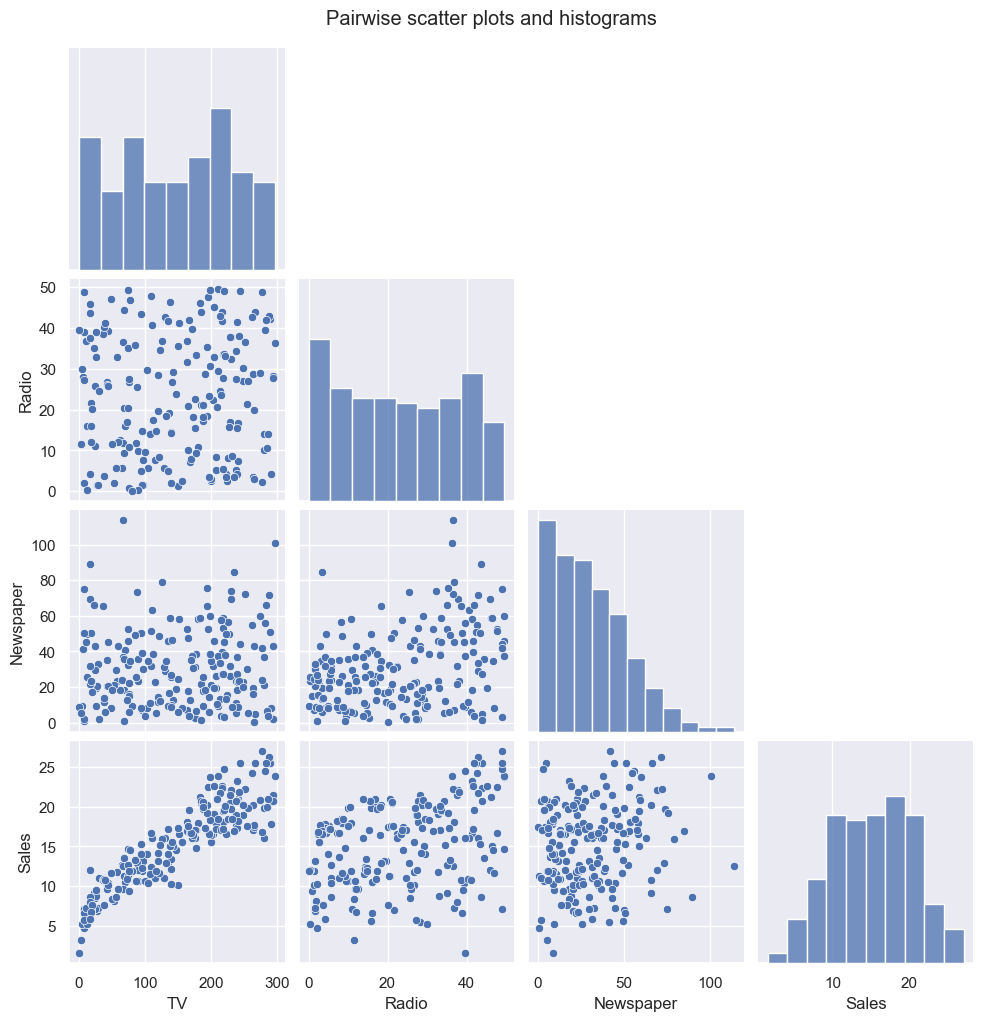

In [24]:
g = sns.pairplot(data_lr,  corner=True)
g.fig.suptitle("Pairwise scatter plots and histograms", y = 1.02) # y= some height>1
plt.show()

The variable TV appears to exhibit the strongest linear relationship with Sales. Therefore, let's build a simple linear regression model using TV as our feature variable.

In [25]:
X = data_lr['TV'] # define the feature
Y = data_lr['Sales'] # define the response variable

Before modeling, it is necessary to randomly split our data into two independent subsets: one for training the model and the other for testing/evaluating the performance of the trained model. This step is essential to help avoid (at least mitigate) model overfitting, which refers to the situation where the model becomes too closely aligned with the training data and fails to generalize well to future data.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 100)

To build a simple linear regression model, we will utilize the statsmodels package. However, there are many other free tools available, such as sklearn. Statsmodels is chosen here because of its results table, which I personally prefer. :)

In [27]:
import statsmodels.api as sm

In [28]:
# Add a constant to get an intercept
X_train = sm.add_constant(X_train)

# Fit the resgression line using 'OLS'
slr = sm.OLS(Y_train, X_train).fit()

We can print the fitted parameters $\beta_0$ and $\beta_1$ (the intercept and coefficient for TV) from the above equation. More detailed information about the results can be obtained by printing slr.summary()

In [29]:
# Print the intercept and the slope
slr.params

# print the result table
# print(slr.summary())

const   6.996
TV      0.054
dtype: float64

To better understand how linear regression works, the fitted line is added to the original scatter plot. The model will make predictions on this line for any future explanatory data. 

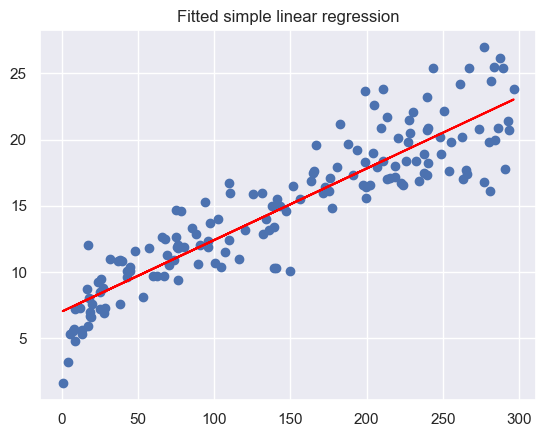

In [30]:
plt.scatter(X_train['TV'], Y_train)
plt.plot(X_train['TV'], slr.params[0] + slr.params[1]*X_train['TV'], 'red')
plt.title('Fitted simple linear regression')
plt.show()

<font color='red'>*How can we interprete the results?* </font>

We can utilize multiple features to predict the target variable using linear regression. In the example above, we will be fitting a linear combination of the money spent on TV, Radio, and Newspaper to predict sales. This implies that we aim to find the best estimates of $\beta_0, \beta_1, \beta_2, \beta_3$ by minimizing the mean squared error (MSE) in the following equation:
$$
\text{Sales} = \beta_0 + \beta_1 \text{TV} + \beta_2 \text{Radio} + \beta_3 \text{Newspaper}
$$

<font color='red'>*Challenge: Code it by yourself* </font>

Linear regression provides unbounded predictions, which can take values from $-\infty$ to $\infty$. Hence, it is not suitable for classification tasks where we require __predicted probabilities for each possible categorical label__.

Logistic regression is specifically designed for binary classification tasks, where the output labels are typically either 0 or 1. It estimates the probability of having a label of 1. For instance, in the context of the Titanic tragedy, we can denote 1 for 'survived' and 0 for 'did not survive'. Logistic regression predicts the probability of survival:
$$
\mathbb{P}(\text{Survived} == 1|X).
$$
Here, $X$ represents the independent variables such as age, sex, and embarked location.

In [31]:
# Source of the picture: https://dzone.com/articles/machinex-simplifying-logistic-regression
Image(url = 'https://rajputhimanshu.files.wordpress.com/2018/03/linear_vs_logistic_regression.jpg')

The plot on the right-hand side exhibits a 'sigmoid function,' which is used by logistic regression to transform the linear combination of independent variables into probabilities. In simple logistic regression, the model fits and predicts the probability of $Y$ being 1 given $X$:

$$
\mathbb{P}(Y = 1|X) = \text{sigmoid}(X) = \frac{1}{1+e^{-(\beta_0 + \beta_1 X_1)}}.
$$

Now, let's fit a logistic regression to predict the probability of survival in the Titanic tragedy using Fare as the only variable.

In [32]:
X = data['Fare']
Y = data['Survived']

# split the data into training and testing, train the model on the training set, and evalute it on the test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, random_state = 100)

# adding the intercept term to the model
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

We first fit the model on the training set.

In [33]:
# Fit a logistic regression
logit_reg = sm.Logit(Y_train, X_train).fit()

# Print the estimations of the parameters
print(logit_reg.params)

# More details can be found by printing the summary table
# print(logit_reg.summary())

Optimization terminated successfully.
         Current function value: 0.620310
         Iterations 6
const   -0.991
Fare     0.015
dtype: float64


Then, we make predictions on the testing set using the fitted model and evaluate its performance. Remember that logistic regression predicts the probability of having a label of 1.

In [35]:
# This is the predicted probability of having a label of 1
pred_prob = logit_reg.predict(X_test)

pred_prob

205   0.303
44    0.295
821   0.297
458   0.303
795   0.311
       ... 
247   0.316
259   0.355
353   0.327
783   0.346
852   0.318
Length: 179, dtype: float64

We can convert the predicted probabilities into integers using a threshold of 0.5. That is, we predict a label of 1 if the predicted probability is greater than 0.5, and predict a label of 0 otherwise.

In [36]:
pred_labels = [1 if prob>0.5 else 0 for prob in pred_prob]

pred_labels[0:10]

[0, 0, 0, 0, 0, 1, 0, 0, 1, 0]

Finally, let's assess the predictive accuracy on the test data points.

In [37]:
from sklearn.metrics import accuracy_score

# Accuracy score of the model
print('Test accuracy = ', accuracy_score(Y_test, pred_labels))

Test accuracy =  0.6033519553072626


# Exercise <a class="anchor" id="exercise"></a>

1. Think of a few real-world examples where regression and classification models can be built to study interesting problems.
2. Detect potential outliers in the advertising dataset. Discuss potential strategies to handle them.
3. Preprocess the Titanic dataset, (hint: addressing missing values, handling potential outliers, and performing any other necessary steps). Build a logistic regression model using all available features to predict the probability of survival in the Titanic dataset. Compute the predictive accuracy of the model.

References: 

[1] Post: *Everything you need to Know about Linear Regression* (2021) https://www.analyticsvidhya.com/blog/2021/10/everything-you-need-to-know-about-linear-regression/#:~:text=Linear%20regression%20is%20a%20type,line%20that%20describes%20the%20relationship

[2] Kaggle post: *Sales Prediction (Simple Linear Regression)* https://www.kaggle.com/code/ashydv/sales-prediction-simple-linear-regression

[3] Post: *Identifying, Cleaning and replacing outliers | Titanic Dataset* https://medium.com/analytics-vidhya/identifying-cleaning-and-replacing-outliers-titanic-dataset-20182a062893

# Suggested reading: <a class="anchor" id="reading"></a>

Python sklearn package for data pre-processing: https://scikit-learn.org/stable/modules/preprocessing.html

Dealing with imbalanced data:

*'SMOTE: Synthetic Minority Over-sampling Technique'*, N. V. Chawla, K. W. Bowyer, L. O. Hall, W. P. Kegelmeyer (2011) https://arxiv.org/abs/1106.1813

Python 'imbalance-learn' pacakge documentation: https://imbalanced-learn.org/stable/user_guide.html#user-guide

Introduction to machine learning:

*Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems 3rd Edition*, Aurélien Géron